In [1]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from plotting import validation_titration_plot, COLOR_PURPLE
from data_loading import load_PDI_luciferase_validation_experiment

In [2]:
df = load_PDI_luciferase_validation_experiment()

In [3]:
df['Set'].value_counts()

eY1Hvalidation    141
Name: Set, dtype: int64

In [4]:
# TODO summary stats
print('In PDI validation experiment, tested:')
print(df['gene_symbol'].nunique(), 'different TF genes')
print(df['clone_acc'].nunique(), 'different TF isoforms')
print(df['Bait'].nunique(), 'different baits')
print(df.shape[0], 'total PDIs')

In PDI validation experiment, tested:
19 different TF genes
48 different TF isoforms
41 different baits
141 total PDIs


In [5]:
print('Isoforms per gene:')
df.groupby(['gene_symbol'])['clone_acc'].nunique().value_counts().sort_index()

Isoforms per gene:


2     9
3    10
Name: clone_acc, dtype: int64

In [6]:
print('Baits per isoform:')
df.groupby(['clone_acc'])['Bait'].nunique().value_counts().sort_index()

Baits per isoform:


2    18
3    15
4    15
Name: Bait, dtype: int64

In [7]:
df['Interaction?'].value_counts()

yes    86
no     55
Name: Interaction?, dtype: int64

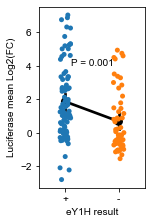

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=3.)
sns.stripplot(data=df, x='Interaction?', y='Log2(FC)', ax=ax, order=['yes', 'no'])
sns.pointplot(data=df, x='Interaction?', y='Log2(FC)', ax=ax, order=['yes', 'no'],
              color='black')
effectsize, pvalue = stats.ttest_ind(df.loc[df['Y1H_positive'], 'Log2(FC)'].values,
                df.loc[~df['Y1H_positive'], 'Log2(FC)'].values)
ax.text(x=0.5, y=4, s='P = {:.1}'.format(pvalue), ha='center')
ax.set_xlabel('eY1H result')
ax.set_xticklabels(['+', '-'])
ax.set_ylabel('Luciferase mean Log2(FC)')
fig.savefig('../figures/PDI-luciferase_validation_point-plot.pdf',
            bbox_inches='tight')

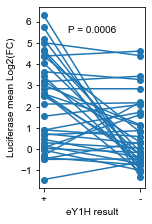

In [9]:
# averaging over each gene/bait with both positive and negative isoforms
avrg_paired = (df.groupby(['gene_symbol', 'Bait', 'Interaction?'])
    ['Log2(FC)']
    .mean()
    .reset_index()
    .pivot(columns='Interaction?',
           index=['gene_symbol', 'Bait'],
           values='Log2(FC)'))
avrg_paired = avrg_paired.dropna()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=3)
for _i, row in avrg_paired.iterrows():
    ax.plot(['+', '-'],
            [row['yes'], row['no']],
            'o-',
            color='C0')
ax.set_xlabel('eY1H result')
ax.set_ylabel('Luciferase mean Log2(FC)')
effectsize, pvalue = stats.ttest_rel(avrg_paired['yes'].values,
                avrg_paired['no'].values)
ax.text(x=0.5, y=5.5, s='P = {:.1}'.format(pvalue), ha='center')
fig.savefig('../figures/PDI-luciferase_validation_pair-plot.pdf',
            bbox_inches='tight')

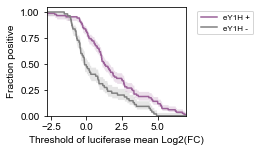

In [10]:
# titration plot of positive vs negative
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=2.)
validation_titration_plot(data=df,
                          selections=[df['Y1H_positive'], 
                                      ~df['Y1H_positive']],
                          score_column='Log2(FC)',
                          labels=['eY1H +', 'eY1H -'],
                          colors=[COLOR_PURPLE, 'grey'],
                          ax=ax)
ax.set_xlabel('Threshold of luciferase mean Log2(FC)')
fig.savefig('../figures/PDI-luciferase_validation_titration-plot.pdf',
            bbox_inches='tight')

In [11]:
def p_value(row):
    a = row[['Replicate1', 'Replicate2', 'Replicate3']].values
    b = row['Average (empty-pEZY3-VP160)']
    # added the list call because I was getting a weird error
    return stats.ttest_1samp(list(a), b, alternative='greater').pvalue

df['p-value'] = df.apply(p_value, axis=1)

In [12]:
df['positive'] = (df['p-value'] < 0.05) & (df['Log2(FC)'] >= 1)

In [13]:
df.groupby('Interaction?')['positive'].mean()

Interaction?
no     0.309091
yes    0.593023
Name: positive, dtype: float64

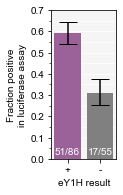

In [14]:
from plotting import COLOR_PURPLE

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.6, h=2.6)
validation_plot(data=df,
                          selections=[df['Y1H_positive'], 
                                      ~df['Y1H_positive']],
                          result_column='positive',
                          labels=['+', '-'],
                          colors=[COLOR_PURPLE, 'grey'],
                          errorbar_capsize=0.25,
                          ax=ax)
ax.set_ylim(0, 0.7)
ax.set_xlabel('eY1H result')
ax.set_ylabel('Fraction positive\nin luciferase assay')
fig.savefig('../figures/PDI-luciferase_validation_bar-plot.pdf',
            bbox_inches='tight')

In [15]:
stats.fisher_exact([[51, 86-51], [17, 55-17]])

SignificanceResult(statistic=3.257142857142857, pvalue=0.0010981868706350598)